In [2]:
import mysql.connector
import pandas as pd
import numpy as np  
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import json
from scipy import stats
import os
import _pickle as cPickle

os.chdir("C:/Users/Nicholas Bonaker/PycharmProjects/NomonWeb/")

def save_pvalues(dict):
    pickle_path = 'D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/pvalues.pkl'
    if os.path.exists(pickle_path):
        with open(pickle_path, 'rb') as fp:
            pvalue_dict = cPickle.load(fp)
    else:
        pvalue_dict = {}
        
    
    for key in dict.keys():
        pvalue_dict[key] = dict[key]
     
    with open(pickle_path, 'wb') as fp:
        cPickle.dump(pvalue_dict, fp)
        
def test_significance(nomon_data, rowcol_data):
    shapiro_stat, shapiro_p = stats.shapiro(nomon_data - rowcol_data)
    
    if shapiro_p <= 0.05:
        print("Normality Assumption Violated. Running Wilcoxin", shapiro_stat, shapiro_p)

        Z_stat, p_value = stats.wilcoxon(nomon_data-rowcol_data)
        r = Z_stat / (len(nomon_data)*(len(nomon_data)+1)/2)
        return {"Z": Z_stat, "r": r, "p": p_value}
    else:
        print("Running Dependant T test")
        t_stat, p_value = stats.ttest_rel(nomon_data, rowcol_data)
        df = len(nomon_data)-1
        r = np.sqrt(t_stat**2/(t_stat**2+df))
        return {"t": t_stat, "r": r, "p": p_value}
    
def calculate_quantiles(plot_df, metric):
    lower_quantiles = plot_df[["Keyboard", "Session Number",metric]].groupby(by=["Keyboard", "Session Number"]).quantile(q=0.25)
    lower_quantiles = lower_quantiles.reset_index()
    nomon_lower_quantiles = lower_quantiles[lower_quantiles.Keyboard == "Nomon"][metric].values
    rowcol_lower_quantiles = lower_quantiles[lower_quantiles.Keyboard == "RCS"][metric].values
    
    upper_quantiles = plot_df[["Keyboard", "Session Number",metric]].groupby(by=["Keyboard", "Session Number"]).quantile(q=0.75)
    upper_quantiles = upper_quantiles.reset_index()
    nomon_upper_quantiles = upper_quantiles[upper_quantiles.Keyboard == "Nomon"][metric].values
    rowcol_upper_quantiles = upper_quantiles[upper_quantiles.Keyboard == "RCS"][metric].values
    
    return {"lower": {"nomon": nomon_lower_quantiles, "rowcol": rowcol_lower_quantiles},
            "upper": {"nomon": nomon_upper_quantiles, "rowcol": rowcol_upper_quantiles}}      
    
    
def r(x, y):
    return x != y


def calc_MSD(a, b):
    
    if a[-1] == "_" or a[-1] == " ":
        a = a[:-1]
    if b[-1] == "_" or b[-1] == " ":
        b = b[:-1]

    a = np.array(list(a))
    b = np.array(list(b))

    D = np.zeros((a.size, b.size))

    for i in range(a.size):
        D[i, 0] = i

    for j in range(b.size):
        D[0, j] = j

    for i in range(a.size):
        for j in range(b.size):
            D[i, j] = min(D[i-1, j]+1, D[i, j-1]+1, D[i-1, j-1] + r(a[i], b[j]))
    return D[-1, -1], D[-1, -1] / b.size

time_rotate_li = [4]
for i in range(21):
    time_rotate_li += [4*np.exp((-i)/10)]
    
scan_delay_li = [2]
for i in range(21):
    scan_delay_li += [2*np.exp((-i)/14)]

extra_delay_li = [2]
for k in range(11):
    extra_delay_li += [0.2*(10-k)]


mydb = mysql.connector.connect(
    host="localhost",
    user="root",
    password="Mala2ki7!",
    database="userDBnew"
)
mycursor = mydb.cursor()

user_df = pd.read_sql('SELECT id, nomon_sessions, rowcol_sessions, dates FROM study_info', con=mydb)

users=[98, 133, 140, 161, 168, 175, 182, 189, 196, 203, 210, 224, 231, 238, 245, 252, 259]
users=[98, 133, 140, 161, 168, 175, 182, 196, 231, 238, 245, 252, 259]

user_df = user_df[user_df["id"].isin(users)].drop_duplicates()
user_df.dates = user_df.dates.apply(lambda x: json.loads(x)[-1])

user_df

,id,nomon_sessions,rowcol_sessions,dates
7,98,10,10,2020-8-21
12,133,10,10,2020-9-11
13,140,10,10,2020-9-11
16,161,10,10,2020-9-14
17,168,10,10,2020-9-11
18,175,10,10,2020-9-13
19,182,10,10,2020-9-12
21,196,10,10,2020-9-7
26,231,10,10,2020-9-3
27,238,10,10,2020-9-13


In [3]:
with open("phrases/phrases_oov.json", 'rb') as fp:
    oov_phrases = json.load(fp)

entry_df = pd.DataFrame(columns=["id", "Session Number", "Keyboard", "phrase_num", "typed_len", "num_click", "num_sel", 
                                 "num_corr", "start", "end", "Final Error Rate", "Time Rotate", 
                                 "Scan Delay", "Extra Delay", "is_oov"])

users = user_df.id.values
software_names = {"nomon": "Nomon", "rowcol": "RCS"}
for user in users:
    print(user)
    for software in software_names.keys():
        software_sessions = user_df[(user_df.id == user)][software+"_sessions"].values[0]
        for session_num in range(1, software_sessions+1):
            data_table = software + "_session_"+str(session_num)+"_user_"+str(user)
            
            mycursor.execute("SELECT DISTINCT phrase_num FROM "+data_table)
            phrase_nums = np.array(mycursor.fetchall()).T[0]
            for phrase_num in phrase_nums:
                trial_data = {"id": user, "Session Number": session_num, "Keyboard": software_names[software], "phrase_num": phrase_num}
                
                mycursor.execute("SELECT abs_click_times FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp ASC")
                click_times = [json.loads(click_arr) for click_arr in np.array(mycursor.fetchall()).T[0]]
                while len(click_times[0]) == 0:
                    click_times = click_times[1:]
                first_press = click_times[0][0]
                num_clicks = sum([len(click_arr) for click_arr in click_times])
                # if (software == "rowcol"):
                #     num_mispress = sum([1 for click_arr in click_times if len(click_arr) >2])
                # else:
                num_mispress = 0
                
                mycursor.execute("SELECT timestamp FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp DESC LIMIT 1")
                last_selection = mycursor.fetchall()[0][0]

                mycursor.execute("SELECT typed_text FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " ORDER BY timestamp DESC LIMIT 1")
                typed_text = mycursor.fetchall()[0][0]
                typed_len = len(typed_text)
                if session_num == 10:
                    typed_len /= 2
                
                mycursor.execute("SELECT phrase FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+ " LIMIT 1")
                phrase_text = mycursor.fetchall()[0][0]

                uncorrected_error = calc_MSD(typed_text, phrase_text)[1]
                
                is_oov = ["IV", "OOV"][phrase_text in oov_phrases]
                
                mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num))
                num_selections = mycursor.fetchall()[0][0]
                
                mycursor.execute("SELECT COUNT(typed_text) FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                 " AND (selection = '@' OR selection = '#' OR selection = 'undefined')")
                num_corrections = mycursor.fetchall()[0][0]
                
                if software == "nomon":
                    mycursor.execute("SELECT rotate_ind FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                     " ORDER BY timestamp DESC LIMIT 1")
                    rotate_ind = mycursor.fetchall()[0][0]
                    trial_data["Time Rotate"] = time_rotate_li[rotate_ind]
                else:
                    mycursor.execute("SELECT scan_delay, extra_delay FROM "+data_table+" WHERE phrase_num = "+str(phrase_num)+
                                     " ORDER BY timestamp DESC LIMIT 1")
                    scan_delay, extra_delay = mycursor.fetchall()[0]
                    trial_data["Scan Delay"] = scan_delay_li[scan_delay]
                    trial_data["Extra Delay"] = extra_delay_li[extra_delay]
                
                
                trial_data["typed_len"] = typed_len
                trial_data["start"] = first_press
                trial_data["end"] = last_selection
                trial_data["num_click"] = num_clicks
                trial_data["num_sel"] = num_selections
                trial_data["num_corr"] = num_corrections + num_mispress
                trial_data["Final Error Rate"] = uncorrected_error
                trial_data["is_oov"] = is_oov
                
                
                entry_df = entry_df.append(trial_data, ignore_index=True)
                

entry_df["Entry Rate (wpm)"] = entry_df.typed_len / (entry_df.end - entry_df.start) / 5 * 60
entry_df["Entry Rate (selections/min)"] = entry_df.typed_len / (entry_df.end - entry_df.start) * 60
entry_df["Click Load (clicks/char)"] = entry_df.num_click / entry_df.typed_len
entry_df["Click Load (clicks/selection)"] = entry_df.num_click / entry_df.num_sel

entry_df["Correction Rate"] = entry_df.num_corr / entry_df.num_sel

entry_df["id"] = pd.to_numeric(entry_df["id"])
entry_df["Session Number"] = pd.to_numeric(entry_df["Session Number"])
entry_df["Entry Rate (wpm)"] = pd.to_numeric(entry_df["Entry Rate (wpm)"])
entry_df["Entry Rate (selections/min)"] = pd.to_numeric(entry_df["Entry Rate (selections/min)"])
entry_df["Click Load (clicks/char)"] = pd.to_numeric(entry_df["Click Load (clicks/char)"])
entry_df["Click Load (clicks/selection)"] = pd.to_numeric(entry_df["Click Load (clicks/selection)"])


entry_df["Correction Rate"] = pd.to_numeric(entry_df["Correction Rate"])
entry_df["Final Error Rate"] = pd.to_numeric(entry_df["Final Error Rate"])
entry_df["Time Rotate"] = pd.to_numeric(entry_df["Time Rotate"])

grouped_df = entry_df.groupby(['id', 'Session Number', 'Keyboard']).agg({'Entry Rate (wpm)': ['mean'],
                                                'Entry Rate (selections/min)': ['mean'],
                                                "Click Load (clicks/char)": ['mean'],
                                                "Click Load (clicks/selection)": ['mean'],
                                                "Correction Rate": ['mean'],
                                                "Final Error Rate": ['mean'],
                                                "Time Rotate": ['mean'],
                                                "Scan Delay": ['mean'],
                                                "Extra Delay": ['mean']})
grouped_df.columns = ['Entry Rate (wpm)', 'Entry Rate (selections/min)', 'Click Load (clicks/char)', "Click Load (clicks/selection)", 'Correction Rate',
                    'Final Error Rate', "Time Rotate", "Scan Delay", "Extra Delay"]
grouped_df = grouped_df.reset_index()


98
133
140
161
168
175
182
196
231
238
245
252
259


<Figure size 432x288 with 0 Axes>

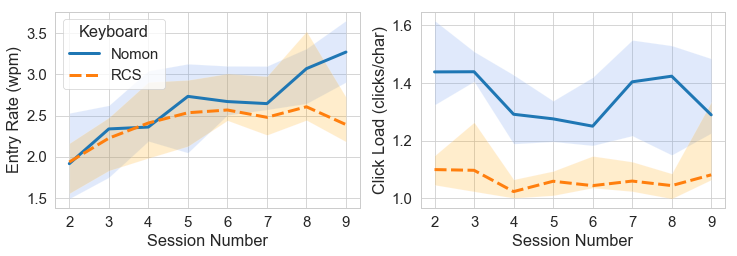

In [3]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
plt.tight_layout()
sns.set_palette("tab10")

plot_df = grouped_df[(grouped_df["Session Number"] > 1) & (grouped_df["Session Number"] < 10)]

metrics = ['Entry Rate (wpm)', "Click Load (clicks/char)"]
a4_dims = (12, 4)
_, axes = plt.subplots(1, 2, figsize=a4_dims)
for ax_ind, metric in enumerate(metrics):
    ax = axes[ax_ind]
    plt.subplots_adjust(bottom=0.2)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    
    sns.lineplot(x="Session Number", y=metric, hue="Keyboard", style="Keyboard", estimator=np.median,
                  data=plot_df, ax=ax, ci=None, linewidth=3)
    
    quantiles = calculate_quantiles(plot_df, metric)
        
    if ax_ind == 1:
        ax.get_legend().remove()
    else:
        leg = ax.get_legend()
        for line in leg.get_lines():
            line.set_linewidth(3)

    
    ax.fill_between(range(2, 10), quantiles["lower"]["nomon"], quantiles["upper"]["nomon"],
                    where=quantiles["upper"]["nomon"] >= quantiles["lower"]["nomon"], facecolor='cornflowerblue', alpha = 0.2, interpolate=True)
    ax.fill_between(range(2, 10), quantiles["lower"]["rowcol"], quantiles["upper"]["rowcol"],
                    where=quantiles["upper"]["rowcol"] >= quantiles["lower"]["rowcol"], facecolor='orange', alpha = 0.2, interpolate=True)



plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/AB_study/figures/entry_and click_load.png", dpi=300)
plt.show()
# a4_dims = (11.7, 8.27)
# _, ax = plt.subplots(figsize=a4_dims)
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# sns.lineplot(x="Session Number", y="Click Load (clicks/char)", hue="Keyboard", 
#              data=grouped_df[(grouped_df["Session Number"] > 1) & (grouped_df["Session Number"] < 10)], ax=ax)
# plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/click_load.png")
# 
# a4_dims = (11.7, 8.27)
# _, ax = plt.subplots(figsize=a4_dims)
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# sns.lineplot(x="Session Number", y="Correction Rate", hue="Keyboard", 
#              data=grouped_df[(grouped_df["Session Number"] > 1) & (grouped_df["Session Number"] < 10)], ax=ax)
# plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/correction_rate.png")
# 
# a4_dims = (11.7, 8.27)
# _, ax = plt.subplots(figsize=a4_dims)
# ax.xaxis.set_major_locator(MaxNLocator(integer=True))
# sns.lineplot(x="Session Number", y="Final Error Rate", hue="Keyboard", 
#              data=grouped_df[(grouped_df["Session Number"] > 1) & (grouped_df["Session Number"] < 10)], ax=ax)
# plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/error_rate.png")


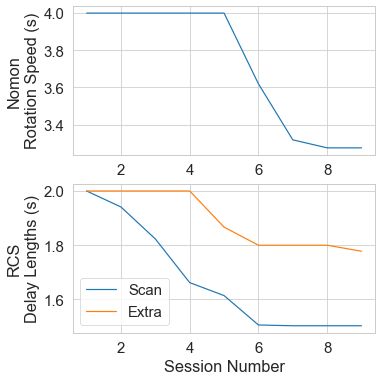

AVG SCAN DELAY:  1.6024722570519316


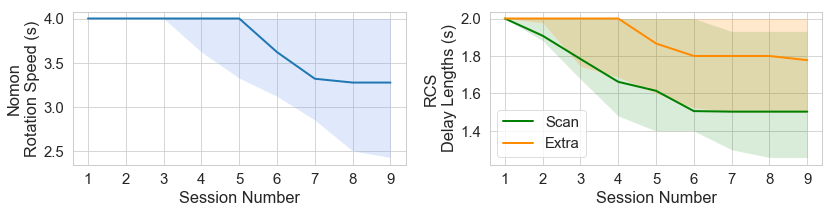

AVG SCAN DELAY:  1.505831359823033


In [19]:
sns.set_context("paper", font_scale=1.7)
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2,figsize=(12,3))
plt.tight_layout(w_pad=3)
plt.subplots_adjust(left=0.1)


ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(x="Session Number", y="Time Rotate", 
             data=grouped_df[grouped_df["Session Number"] < 10], ax=axes[0], ci=None, estimator=np.median, linewidth=2)
axes[0].set_ylabel("Nomon\nRotation Speed (s)")
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
# axes[0].set_xlabel("")

rotate_quantiles = calculate_quantiles(grouped_df[grouped_df["Session Number"] < 10], "Time Rotate")
axes[0].fill_between(range(1, 10), rotate_quantiles["lower"]["nomon"], rotate_quantiles["upper"]["nomon"],
                where=rotate_quantiles["upper"]["nomon"] >= rotate_quantiles["lower"]["nomon"], facecolor='cornflowerblue', alpha = 0.2, interpolate=True)
                
sns.lineplot(x="Session Number", y="Scan Delay", data=grouped_df[grouped_df["Session Number"] < 10], ax=axes[1], 
             label="Scan", ci=None, estimator=np.median, color="green", linewidth=2)
sns.lineplot(x="Session Number", y="Extra Delay", data=grouped_df[grouped_df["Session Number"] < 10], ax=axes[1],
             label="Extra", ci=None, estimator=np.median, color="darkorange", linewidth=2)
axes[1].set_ylabel("RCS\nDelay Lengths (s)")
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].legend(loc='lower left')

scan_quantiles = calculate_quantiles(grouped_df[grouped_df["Session Number"] < 10], "Scan Delay")
axes[1].fill_between(range(1, 10), scan_quantiles["lower"]["rowcol"], scan_quantiles["upper"]["rowcol"],
                where=scan_quantiles["upper"]["rowcol"] >= scan_quantiles["lower"]["rowcol"], facecolor='green', alpha = 0.15, interpolate=True)
 
extra_quantiles = calculate_quantiles(grouped_df[grouped_df["Session Number"] < 10], "Extra Delay")
axes[1].fill_between(range(1, 10), extra_quantiles["lower"]["rowcol"], extra_quantiles["upper"]["rowcol"],
                where=extra_quantiles["upper"]["rowcol"] >= extra_quantiles["lower"]["rowcol"], facecolor='darkorange', alpha = 0.2, interpolate=True)

plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/speed_adjustments.png", dpi=300)
plt.show()

scan_delays = grouped_df[(grouped_df["Session Number"] >= 6) & (grouped_df["Session Number"] < 7)]["Scan Delay"].values
scan_delays = scan_delays[~np.isnan(scan_delays)]
print("AVG SCAN DELAY: ", np.median(scan_delays))

13.0
Entry Rate (wpm) 3.2063311125244214 2.537238676524912
Running Dependant T test
Entry Rate (wpm) {'t': 2.8782728677519156, 'r': 0.6390727433960481, 'p': 0.013875025524347634} 

Click Load (clicks/char) 1.3169968817731652 1.0697648740877126
Normality Assumption Violated. Running Wilcoxin 0.8581861257553101 0.036462537944316864
Click Load (clicks/char) {'Z': 16.0, 'r': 0.17582417582417584, 'p': 0.03924327615032667} 

Correction Rate 0.025732573956258168 0.017049151897601145
Running Dependant T test
Correction Rate {'t': -1.6079778886978733, 'r': 0.4210348343717269, 'p': 0.13381672687336124} 

Final Error Rate 0.0 0.0
Normality Assumption Violated. Running Wilcoxin 0.7931650876998901 0.005660527385771275
Final Error Rate {'Z': 10.0, 'r': 0.10989010989010989, 'p': 0.49896229860376107} 



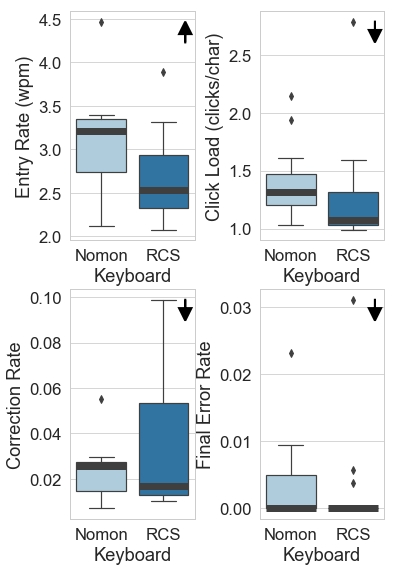

c:\users\nickb\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


{'Final Entry Rate (wpm)': 0.013875025524347634,
 'Final Click Load (clicks/char)': 0.03924327615032667,
 'Final Correction Rate': 0.13381672687336124,
 'Final Final Error Rate': 0.49896229860376107}

In [15]:

sns.set_context("paper", font_scale=1.9)
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Paired"))

final_df = grouped_df[(grouped_df["Session Number"] >= 8) & (grouped_df["Session Number"] < 10)]
final_df = final_df.groupby(['id', 'Keyboard']).agg({'Entry Rate (wpm)': ['mean'],
                                                'Entry Rate (selections/min)': ['mean'],
                                                "Click Load (clicks/char)": ['mean'],
                                                "Correction Rate": ['mean'],
                                                "Final Error Rate": ['mean'],
                                                "Time Rotate": ['mean'],
                                                "Scan Delay": ['mean'],
                                                "Extra Delay": ['mean']})
final_df.columns = ['Entry Rate (wpm)', 'Entry Rate (selections/min)', 'Click Load (clicks/char)', 'Correction Rate',
                    'Final Error Rate', "Time Rotate", "Scan Delay", "Extra Delay"]
final_df = final_df.reset_index()

print(len(final_df.id.values)/2)

entry_stats = ["Entry Rate (wpm)", "Click Load (clicks/char)", "Correction Rate", "Final Error Rate"]
fig, axes = plt.subplots(2, 2,figsize=(6,8))
fig.tight_layout(w_pad=1.6)
plt.subplots_adjust(left=0.2)
axes = list(axes)
# fig.suptitle('Entry Statistics for Sessions 7-9')

indicies = [(0,0), (0,1), (1, 0), (1,1)][::-1]
for entry_stat in entry_stats:
    ind = indicies.pop()
    cur_ax = axes[ind[0]][ind[1]]
    
    sns.boxplot(x="Keyboard", y=entry_stat, data=final_df, ax=cur_ax)
    if entry_stat == "Entry Rate (wpm)":
        y_max = np.max(final_df[entry_stat])
        y_min = np.min(final_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(1.35, y_max - arrow_h, 0, arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
    else:
        y_max = np.max(final_df[entry_stat])
        y_min = np.min(final_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(1.35, y_max, 0, -arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')

    lines = cur_ax.get_lines()
    for median_line in lines[4:len(lines):6]:
        median_line.set_solid_capstyle('butt')
        median_line.set_linewidth(7)
        median_line.set_alpha(1)
    plt.plot()

plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/AB_study/figures/final_sessions_metrics.png", dpi=300)
plt.show()

pvalues = {}
for entry_stat in entry_stats:       
    nomon_data = final_df[final_df.Keyboard == "Nomon"][entry_stat].values
    rowcol_data = final_df[final_df.Keyboard == "RCS"][entry_stat].values
    print(entry_stat, np.median(nomon_data), np.median(rowcol_data))
    
    cur_pvalue = test_significance(nomon_data, rowcol_data)
    print(entry_stat, cur_pvalue, "\n")
    
    pvalues["Final "+ entry_stat] = cur_pvalue['p']

save_pvalues(pvalues)
pvalues


13.0
Entry Rate (selections/min) 6.651308983275632 4.58753526738561
Running Dependant T test
Entry Rate (selections/min) {'t': 5.238526571445211, 'r': 0.8341205143384879, 'p': 0.00020828150909598007} 

Click Load (clicks/char) 3.2500000000000004 2.2266666666666666
Running Dependant T test
Click Load (clicks/char) {'t': 7.733285642502349, 'r': 0.9126213392341814, 'p': 5.311084762912319e-06} 

Correction Rate 0.009523809523809523 0.023809523809523808
Running Dependant T test
Correction Rate {'t': -2.4497223388433276, 'r': 0.5773868163991319, 'p': 0.03060874390779564} 

Final Error Rate 0.0 0.0
Normality Assumption Violated. Running Wilcoxin 0.7199859023094177 0.0008858829969540238
Final Error Rate {'Z': 7.0, 'r': 0.07692307692307693, 'p': 0.892738400944348} 



c:\users\nickb\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


{'Emoji Entry Rate (selections/min)': 0.00020828150909598007,
 'Emoji Click Load (clicks/char)': 5.311084762912319e-06,
 'Emoji Correction Rate': 0.03060874390779564,
 'Emoji Final Error Rate': 0.892738400944348}

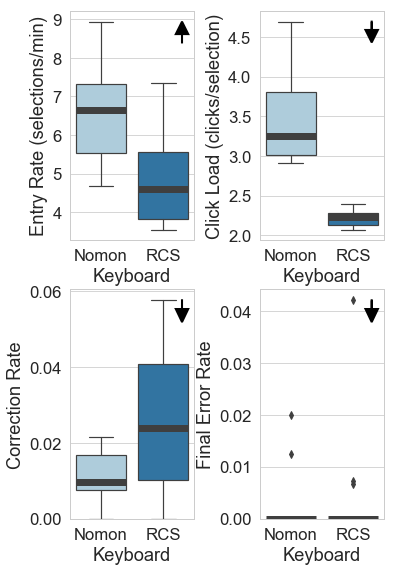

In [ ]:
emoji_df = grouped_df[grouped_df["Session Number"] == 10]
print(len(emoji_df.id.values)/2)

sns.set_context("paper", font_scale=1.9)
sns.set_style("whitegrid")
# sns.set_palette(sns.color_palette("tab10"))
sns.set_palette(sns.color_palette("Paired"))

entry_stats = ["Entry Rate (selections/min)", "Click Load (clicks/char)", "Correction Rate", "Final Error Rate"]
fig, axes = plt.subplots(2, 2,figsize=(6,8))
fig.tight_layout(w_pad=1.6)
plt.subplots_adjust(left=0.2)
axes = list(axes)
# fig.suptitle('Entry Statistics for Sessions 7-9')

indicies = [(0,0), (0,1), (1, 0), (1,1)][::-1]
for entry_stat in entry_stats:
    ind = indicies.pop()
    cur_ax = axes[ind[0]][ind[1]]
    
    sns.boxplot(x="Keyboard", y=entry_stat, data=emoji_df, ax=cur_ax)
    
    if entry_stat == "Entry Rate (selections/min)":
        y_max = np.max(emoji_df[entry_stat])
        y_min = np.min(emoji_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(1.3, y_max - arrow_h, 0, arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
    else:
        y_max = np.max(emoji_df[entry_stat])
        y_min = np.min(emoji_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(1.3, y_max, 0, -arrow_h, head_width=0.2, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
    
    if entry_stat == "Click Load (clicks/char)":
        cur_ax.set_ylabel("Click Load (clicks/selection)")
    
    if cur_ax.get_ylim()[0] < 0:
        cur_ax.set_ylim(bottom=0.)
    # if entry_stat in ["Correction Rate", "Final Error Rate"]:
    #     if cur_ax.get_ylim()[1] < 1:
    #         cur_ax.set_ylim(top=2)
    
    lines = cur_ax.get_lines()
    for median_line in lines[4:len(lines):6]:
        median_line.set_solid_capstyle('butt')
        median_line.set_linewidth(7)
        median_line.set_alpha(1)
        
    plt.plot()
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/AB_study/figures/emoji_metrics.png")

pvalues = {}
for entry_stat in entry_stats:       
    nomon_data = emoji_df[emoji_df.Keyboard == "Nomon"][entry_stat].values
    rowcol_data = emoji_df[emoji_df.Keyboard == "RCS"][entry_stat].values
    print(entry_stat, np.median(nomon_data), np.median(rowcol_data))
    # plt.hist(nomon_data - np.average(nomon_data))
    # plt.hist(rowcol_data - np.average(rowcol_data))
    # plt.show()
    try:
        cur_pvalue = test_significance(nomon_data, rowcol_data)
        print(entry_stat, cur_pvalue, "\n")
        pvalues["Emoji "+ entry_stat] = cur_pvalue['p']
    except(ValueError):
        pass

save_pvalues(pvalues)
pvalues


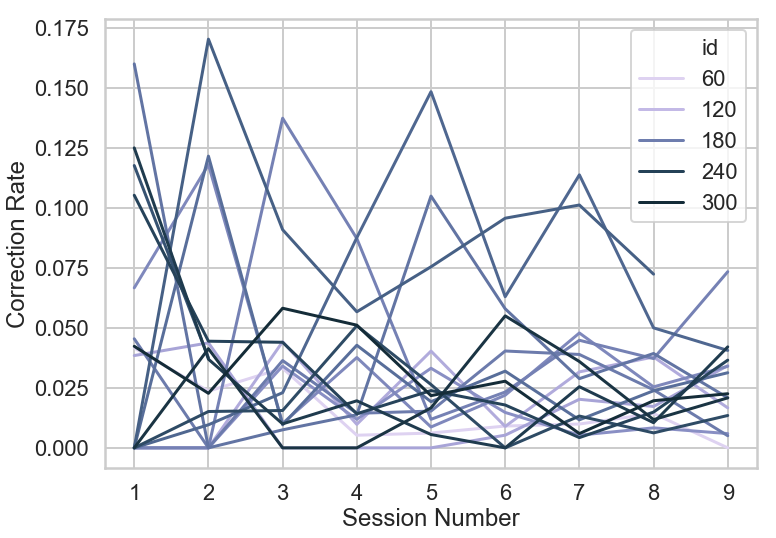

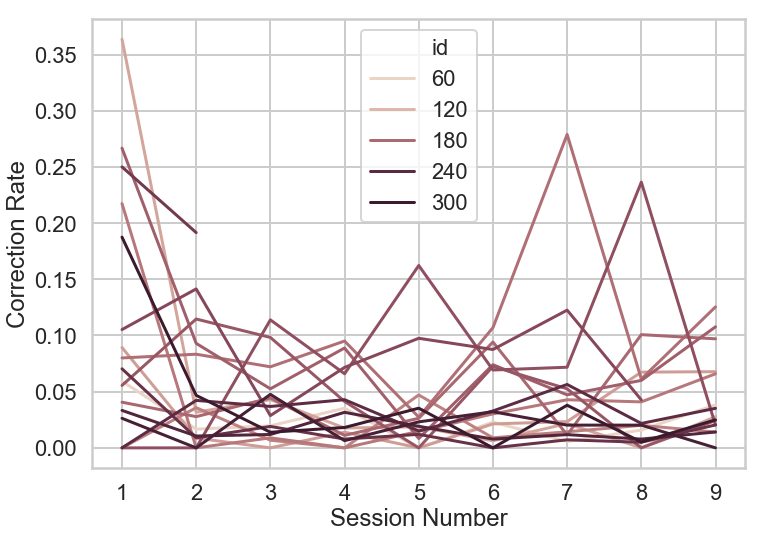

In [27]:
sns.set_context("poster")
sns.set_style("whitegrid")

a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
sns.lineplot(x="Session Number", y="Correction Rate", hue="id",
              data=grouped_df[(grouped_df["Session Number"] > 0) & (grouped_df["Session Number"] <= 9) & 
                            (grouped_df["Keyboard"] == "Nomon")], ax=ax, palette="ch:2.5,.25", ci=None)

a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)

sns.lineplot(x="Session Number", y="Correction Rate", hue="id",
              data=grouped_df[(grouped_df["Session Number"] > 0) & (grouped_df["Session Number"] <= 9) & 
                            (grouped_df["Keyboard"] == "RCS")], ax=ax, palette="ch:0.5,.25", ci=None)

<AxesSubplot:xlabel='Session Number', ylabel='Correction Rate (%)'>

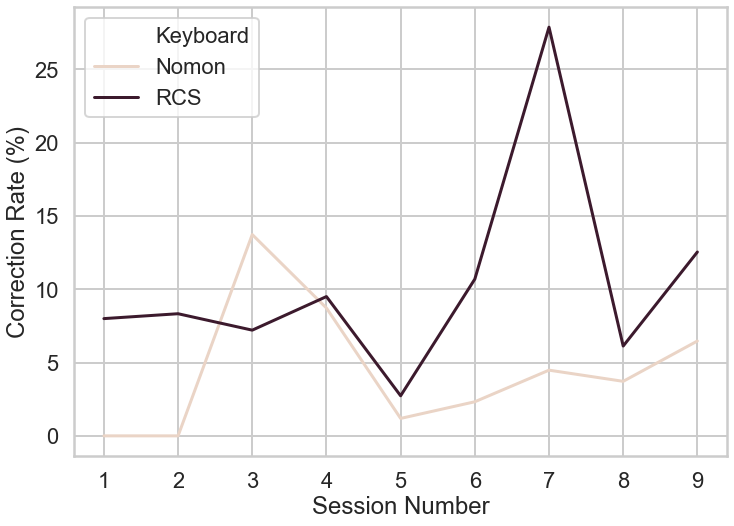

In [23]:
a4_dims = (11.7, 8.27)
_, ax = plt.subplots(figsize=a4_dims)
sns.lineplot(x="Session Number", y="Correction Rate", hue="Keyboard",
              data=grouped_df[(grouped_df["Session Number"] > 0) & (grouped_df["Session Number"] <= 9) & 
                            (grouped_df["id"] == 175)], ax=ax, palette="ch:0.5,.25", ci=None)

Entry Rate (wpm) 2.4303794121534494 1.8177779687974016
Running Dependant T test
Final Error Rate {'t': 3.949310437468764, 'r': 0.6198320361018398, 'p': 0.0005642675575534525} 

Entry Rate (wpm) 3.369334554462872 2.9164923666157763
Running Dependant T test
Final Error Rate {'t': 2.252356283157527, 'r': 0.41072196245863724, 'p': 0.033327558396711685} 

Correction Rate 0.022048872180451123 0.034758454106280194
Running Dependant T test
Final Error Rate {'t': -2.084642379466072, 'r': 0.38482127595050936, 'p': 0.047473310126996585} 

Correction Rate 0.016411701556629094 0.01633333333333333
Normality Assumption Violated. Running Wilcoxin 0.895509660243988 0.012445293366909027
Final Error Rate {'Z': 113.0, 'r': 0.32193732193732194, 'p': 0.18289563683046106} 



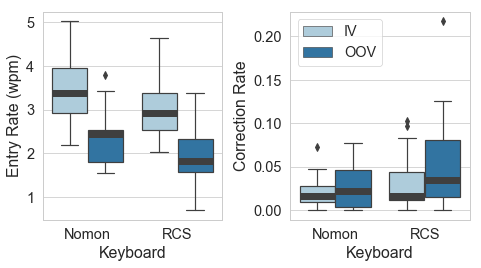

In [29]:
oov_df = entry_df.groupby(['id', 'Session Number', 'Keyboard', 'is_oov']).agg({'Entry Rate (wpm)': ['mean'],
                                                'Entry Rate (selections/min)': ['mean'],
                                                "Click Load (clicks/char)": ['mean'],
                                                "Correction Rate": ['mean'],
                                                "Final Error Rate": ['mean']})
oov_df.columns = ['Entry Rate (wpm)', 'Entry Rate (selections/min)', 'Click Load (clicks/char)', 'Correction Rate',
                    'Final Error Rate']
oov_df = oov_df.reset_index()
oov_df = oov_df[(oov_df["Session Number"] < 10) & (oov_df["Session Number"] >=8)]

fig, axes = plt.subplots(1, 2,figsize=(7,4))
fig.tight_layout(w_pad=1.6)
plt.subplots_adjust(bottom=0.2)

sns.set_context("paper", font_scale=1.65)
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Paired"))

for ax_ind, metric in enumerate(['Entry Rate (wpm)', "Correction Rate"]):
    ax = axes[ax_ind]
    sns.boxplot(x="Keyboard", y=metric, hue='is_oov', data=oov_df, ax=ax)
    lines = ax.get_lines()
    for median_line in lines[4:len(lines):6]:
        median_line.set_solid_capstyle('butt')
        median_line.set_linewidth(7)
        median_line.set_alpha(1)
    
    if ax_ind == 0:
        ax.get_legend().remove()
    else:
        ax.get_legend().set_title('')
        
    nomon_data = oov_df[(oov_df.Keyboard == "Nomon") & (oov_df.is_oov == "OOV")][metric].values
    rowcol_data = oov_df[(oov_df.Keyboard == "RCS") & (oov_df.is_oov == "OOV")][metric].values
    if (len(rowcol_data) > len(nomon_data)):
        rowcol_data = rowcol_data[:-1]
        
    print(metric, np.median(nomon_data), np.median(rowcol_data))
    # 
    cur_pvalue = test_significance(nomon_data, rowcol_data)
    print(entry_stat, cur_pvalue, "\n")
    
    nomon_data = oov_df[(oov_df.Keyboard == "Nomon") & (oov_df.is_oov == "IV")][metric].values
    rowcol_data = oov_df[(oov_df.Keyboard == "RCS") & (oov_df.is_oov == "IV")][metric].values
    print(metric, np.median(nomon_data), np.median(rowcol_data))
    # 
    cur_pvalue = test_significance(nomon_data, rowcol_data)
    print(entry_stat, cur_pvalue, "\n")
plt.savefig("D:/Users/nickb/PycharmProjectsD/NomonWeb/data_processing/figures/oov_metrics.png", dpi=300)



C:\Users\Nicholas Bonaker\AppData\Roaming\Python\Python37\site-packages\seaborn\categorical.py:1296: UserWarning: 30.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


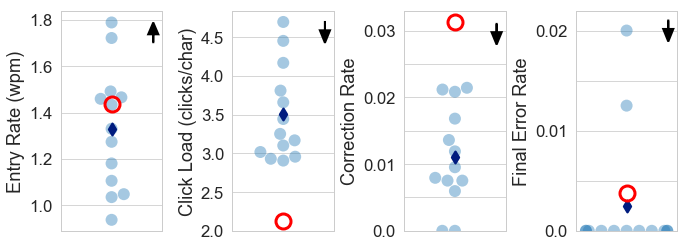

In [30]:
final_df = grouped_df[(grouped_df["Session Number"] >= 10) & (grouped_df["Session Number"] <22) & (grouped_df["Keyboard"] == "Nomon")]
final_df = final_df.groupby(['id', 'Keyboard']).agg({'Entry Rate (wpm)': ['mean'],
                                                'Entry Rate (selections/min)': ['mean'],
                                                "Click Load (clicks/char)": ['mean'],
                                                "Click Load (clicks/selection)": ['mean'],
                                                "Correction Rate": ['mean'],
                                                "Final Error Rate": ['mean'],
                                                "Time Rotate": ['mean'],
                                                "Scan Delay": ['mean'],
                                                "Extra Delay": ['mean']})
final_df.columns = ['Entry Rate (wpm)', 'Entry Rate (selections/min)', 'Click Load (clicks/char)', 'Click Load (clicks/selection)','Correction Rate',
                    'Final Error Rate', "Time Rotate", "Scan Delay", "Extra Delay"]
final_df = final_df.reset_index()

sns.set_context("paper", font_scale=1.9)
sns.set_style("whitegrid")

entry_stats = ["Entry Rate (wpm)", "Click Load (clicks/char)", "Correction Rate", "Final Error Rate"]
fig, axes = plt.subplots(1, 4,figsize=(10,4))
fig.tight_layout(w_pad=1.6)
plt.subplots_adjust(left=0.1)
axes = list(axes)
i=0

axes[0].plot(np.mean([1.435]), marker='o', fillstyle='none', markersize=15, markeredgewidth=3, color="red")
axes[1].plot(np.mean([2.128]), marker='o',fillstyle='none', markersize=15, markeredgewidth=3, color="red")
axes[2].plot(np.mean([0.03125]), marker='o',fillstyle='none', markersize=15, markeredgewidth=3, color="red")
axes[3].plot(np.mean([0.00375]), marker='o',fillstyle='none', markersize=15, markeredgewidth=3, color="red")


for entry_stat in entry_stats:
    cur_ax = axes[i]
    
    if entry_stat == "Entry Rate (wpm)":
        y_max = np.max(final_df[entry_stat])
        y_min = np.min(final_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(0.41, y_max - arrow_h, 0, arrow_h, head_width=0.1, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')

    elif entry_stat == "Click Load (clicks/char)":
        y_max = np.max(final_df[entry_stat])
        y_min = 2
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(0.41, y_max, 0, -arrow_h, head_width=0.1, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
    
    elif entry_stat == "Correction Rate":
        y_max = 0.031
        y_min = np.min(final_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(0.41, y_max, 0, -arrow_h, head_width=0.1, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
        cur_ax.yaxis.set_ticks(np.array([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]))
        cur_ax.set_yticklabels(["0.0", "0.05", "0.01", "0.015", "0.02", "0.025", "0.03"])
        
        j=0
        for label in cur_ax.yaxis.get_ticklabels():
            if j%2:
                label.set_visible(False)
            j+=1
    else:
        y_max = 0.021
        y_min = np.min(final_df[entry_stat])
        arrow_h = (y_max-y_min)*0.1
        cur_ax.arrow(0.41, y_max, 0, -arrow_h, head_width=0.1, head_length=arrow_h*0.6, linewidth=2, length_includes_head=True, color='k')
        cur_ax.yaxis.set_ticks(np.array([0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03]))
        cur_ax.set_yticklabels(["0.0", "0.05", "0.01", "0.015", "0.02", "0.025", "0.03"])
        
        j=0
        for label in cur_ax.yaxis.get_ticklabels():
            if j%2:
                label.set_visible(False)
            j+=1
            
    sns.swarmplot(y=entry_stat,
                  data=final_df, dodge=True, alpha=.4, zorder=1, ax=cur_ax, size=12)
    
    sns.pointplot(y=entry_stat,
                  data=final_df, dodge=.8 - .8 / 3,
                  join=False, palette="dark",
                  markers="d", scale=1.5, ci=None, ax=cur_ax)
    
    
    
    if cur_ax.get_ylim()[0] < 0:
        cur_ax.set_ylim(bottom=0.)
        
    # if entry_stat == "Final Error Rate":
    #     cur_ax.set_ylim(top=0.032)
        
    # if cur_ax.get_ylim()[1] < 0.1:
    #     cur_ax.set_ylim(top=0.1)
    i+=1

plt.savefig("data_processing/MI_study/figures/claire_text_ab_comparison_mean.png", dpi=300)
   

